In [9]:
using NPZ
using Interpolations
using Cubature
using PyCall
using LinearAlgebra
using BenchmarkTools
# mpb = pyimport("meep.mpb")
# mp = pyimport("meep")
# @pyimport matplotlib.animation as anim
using PyPlot
# using Plots
# pyplot()
include("xray_3dphc.jl")

read_phc_data (generic function with 1 method)

In [10]:
# data = npzread("phc3d_more_g.npz")
# data= npzread("phc3d_constant_eps.npz")
data = npzread("phc_an_files/phc3d_sc_spheres_e_13_15_12b.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
# krange = -0.75:Δk:0.75
krange = -0.5:Δk:0.5

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
# ks = range(-0.75,0.75,length=70)
ks = range(-0.5,0.5,length=70)


-0.5:0.014492753623188406:0.5

In [3]:
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    # replace zeros with an average so we don't go into a bandgap...
    ωband = ωdat[b,:,:,:]
#     avg = mean(ωband[ωband.!=0])
#     ωband[ωband.==0] .= avg
#     if ωdat[b,k0,k0,k0] == 0
#         ωband[k0,k0,k0] = 0
#     end
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
#     ωitp = interpolate(ωdat[b,:,:,:], BSpline(Linear()));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

In [4]:
Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
# ks_1BZ_BCC = [in_1BZ_BCC(BCC_to_cartesian_recip * [kx, ky, kz]) ? 1 : 0 for kx in krange, ky in krange, kz in krange]
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
#                     Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Linear()));

                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Quadratic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end

In [7]:
ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [1, 0, 0]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
# a = 0.5e-6 #PhC lattice spacing
a = 0.5e-6 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_sc = PhC_Data(a, Msplines, ωsplines, 0);

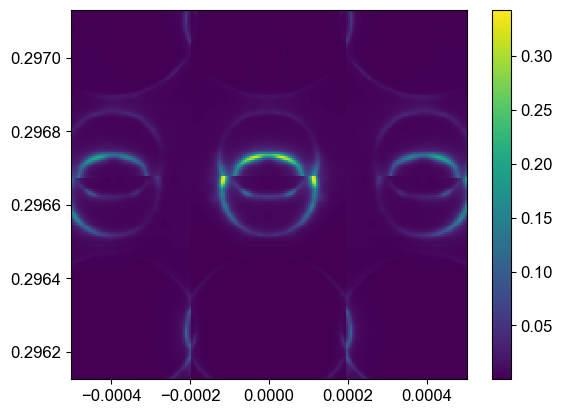

344.64061545522117


In [8]:
ωi = 1.2/ħeV #2/ħeV
Nangles = 200
θdev = 0.0005
ϕdev = 0.0005
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, b, 1, lz=0.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

pcolormesh(ϕrange, θrange, dat)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])
println(sum(dat))

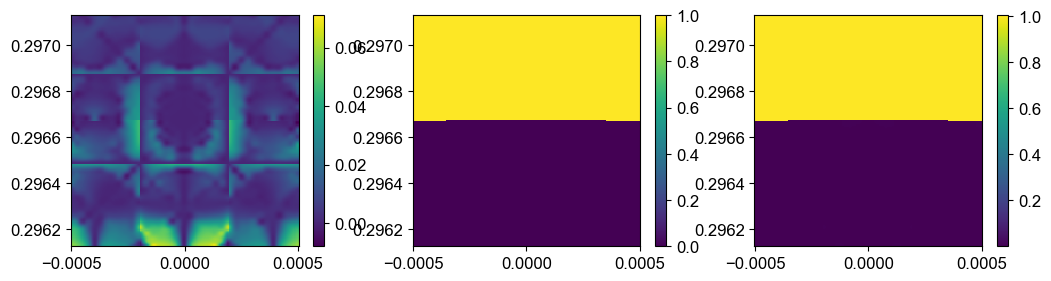

PyObject <matplotlib.colorbar.Colorbar object at 0x7f16c5fa11d0>

In [83]:
# noffset, k0_vec_no_unit, M02, ωi, lor, Ep2, prefactor, kBvec, [Msplines[i](k0x, k0y, k0z) for i in 1:3]
# Threads.@threads for b in 1:Nb
#     newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=0.2e14)*cos(θs)
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end
subplots(1,3,figsize=(12.5,3))
subplot(1,3,1)
dat1 = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[9][1]
                        for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat1)
colorbar()

subplot(1,3,2)
dat2 = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[1][1]
                        for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat2)
colorbar()

subplot(1,3,3)
dat3 = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[9][3]
                       for θs in θrange, ϕs in ϕrange]
# dat3 = dat1 .* dat2

pcolormesh(ϕrange, θrange, dat1.^2 .+ dat2.^2 .+ dat3.^2)
colorbar()


In [60]:
marr = info_SC(ωp - ωi, θrange[20], ϕrange[30], gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[9]

3-element Array{Float64,1}:
 0.007305748272277999
 0.01537148828811732
 0.00919155560367135

In [63]:
sum((marr.* normalize(gvec)).^2)

5.3373957817892964e-5

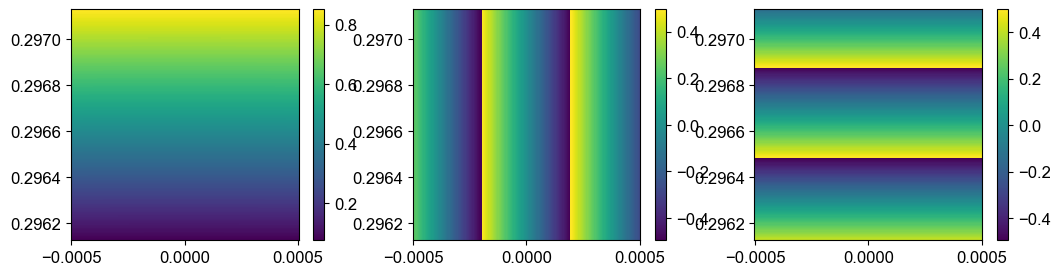

PyObject <matplotlib.colorbar.Colorbar object at 0x7f16ccbaa890>

In [79]:
# noffset, k0_vec_no_unit, M02, ωi, lor, Ep2, prefactor, kBvec, [Msplines[i](k0x, k0y, k0z) for i in 1:3]
# Threads.@threads for b in 1:Nb
#     newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=0.2e14)*cos(θs)
#                         for θs in θrange, ϕs in ϕrange]
#     global dat .+= newdat
# end
subplots(1,3,figsize=(12.5,3))
subplot(1,3,1)
dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[2][1] - info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[1][1]
                        for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat)
colorbar()

subplot(1,3,2)
dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[2][2]
                        for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat)
colorbar()

subplot(1,3,3)
dat = [info_SC(ωp - ωi, θs, ϕs, gvec, P, D_sc, χ, np, L, 1, 1, lz=0.2e14)[2][3]
                        for θs in θrange, ϕs in ϕrange]

pcolormesh(ϕrange, θrange, dat)
colorbar()


In [21]:
# data = npzread("phc3d_more_g.npz")
# data= npzread("phc3d_constant_eps.npz")
data = npzread("phc_an_files/phc3d_wdpl_21_e_13.npz")

kBZ = data["arr_0"]
Δk = kBZ[2] - kBZ[1]
krange = -0.75:Δk:0.75
# krange = -0.5:Δk:0.5

M1dat = data["arr_1"]
M2dat = data["arr_2"]
M3dat = data["arr_3"]
ωdat = data["arr_4"]
vgdat = data["arr_5"];

Nb = size(ωdat)[1]
NM = size(M1dat)[5]
Nk = size(ωdat)[2]
ks = range(-0.75,0.75,length=70)
# ks = range(-0.5,0.5,length=70)


-0.75:0.021739130434782608:0.75

In [22]:
ωsplines = Array{Any,1}(undef, Nb)
k0 = Integer((Nk+1)/2) # Nk must be odd

for b in 1:Nb
    # replace zeros with an average so we don't go into a bandgap...
    ωband = ωdat[b,:,:,:]
#     avg = mean(ωband[ωband.!=0])
#     ωband[ωband.==0] .= avg
#     if ωdat[b,k0,k0,k0] == 0
#         ωband[k0,k0,k0] = 0
#     end
    
    ωitp = interpolate(ωband, BSpline(Quadratic(Flat(OnCell()))));
#     ωitp = interpolate(ωdat[b,:,:,:], BSpline(Linear()));
    ωsitp = scale(ωitp, krange, krange, krange);
    ωsplines[b] = ωsitp
end

In [23]:
Msplines = Array{Any,5}(undef, Nb, NM, NM, NM, 3)
# ks_1BZ_BCC = [in_1BZ_BCC(BCC_to_cartesian_recip * [kx, ky, kz]) ? 1 : 0 for kx in krange, ky in krange, kz in krange]
for i in 1:3
    key = string("arr_", i)
    Mdat = data[key]
    for b in 1:Nb
        for nx in 1:NM
            for ny in 1:NM
                for nz in 1:NM
#                     Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Linear()));

                    Mitp = interpolate(Mdat[b,:,:,:,nx,ny,nz], BSpline(Quadratic(Flat(OnCell()))));
                    Msitp = scale(Mitp, krange, krange, krange);
                    Msplines[b,nx,ny,nz,i] = Msitp
                end
            end
        end
    end
end

In [24]:
ωp = 1e19
ωi = 2e15
ωs = ωp - ωi
#dmnd and ln
# g = 3.1e10 #being approximate here
# ga
g = 1.95e10
gvec = g * [1,0,0]
θB = asin(g*c/(2*ωp))
# println(θB)

# χ = 2e-17 #dmmd
# χ = 1.3e-13 # LN
χ = 4.7e-14 # GA
np = 1e14
# a = 0.5e-6 #PhC lattice spacing
a = 0.5e-6 # free space lattice spacing.... get more accurate modes??
L = 1e-4 #1mm where period is micron scale sounds reasonable

θdev = 0.0005
ϕdev = 0.0005

P = PumpBeam(1e19, θB, 0.0)
D_fcc = PhC_Data(a, Msplines, ωsplines, 0);

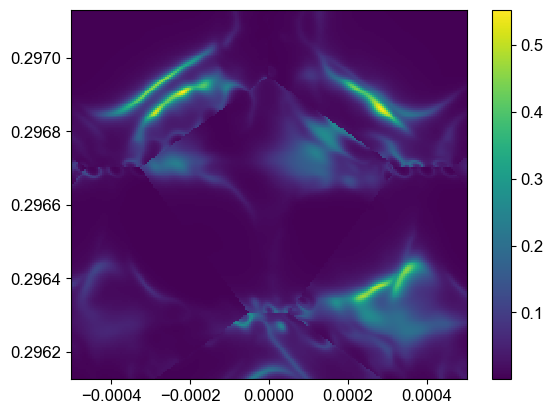

1712.028387636511


In [32]:
ωi = 1.6/ħeV
Nangles = 200
θdev = 0.0005
ϕdev = 0.0005
dat = zeros(Nangles,Nangles)
θrange = range(θB - θdev, θB + θdev, length=Nangles)
ϕrange = range(-ϕdev, ϕdev, length=Nangles)
Δθ = θrange[2]-θrange[1]
Δϕ = ϕrange[2]-ϕrange[1]

# noffset, k0_vec_no_unit, k_r, M0, ωi, lor, M02
Threads.@threads for b in 1:Nb
    newdat = [dΓdωdΩ_stitch_FCC(ωp - ωi, θs, ϕs, gvec, P, D_fcc, χ, np, L, b, 1, lz=0.2e14)*cos(θs)
                        for θs in θrange, ϕs in ϕrange]
    global dat .+= newdat
end

pcolormesh(ϕrange, θrange, dat)
colorbar()
# PyPlot.contour(ϕrange, θrange, colors1m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors2m, levels=-5.5:5.5, colors=["white"])
# PyPlot.contour(ϕrange, θrange, colors3m, levels=-5.5:5.5, colors=["white"])
println(sum(dat))

In [82]:
function dΓdωdΩ_SC(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a

    kBz = -ks*sin(θs) - kp*sin(θp) + gvec[3]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBx = - ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[1]

    kBvec = [kBx, kBy, kBz]# .+ Goffset # in meters

#     k0_vec_no_unit = kBvec * a / (2π)

    k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5 # in MPB units
    if !in_BZ(k0_vec_no_unit)
#         println("why are we here")
        return 0
    end
    
    noffset = -floor.(kBvec*a/(2π) .+ 0.5)
    
    # We only have mode overlap data for the first 3 offsets in all directions
    if any(abs.(noffset) .> 3)
        return 0
    end
    nx, ny, nz = noffset .+ [4,4,4]
#     println(nx, ny, nz)

    Msplines = [D.Mspline[band, Integer(nx), Integer(ny), Integer(nz), i] for i in 1:3]

    ωspline = D.ωspline[band]
    
    k0x, k0y, k0z = k0_vec_no_unit

    ω0 = ωspline(k0x, k0y, k0z)
#     M0 = Mspline(k0x, k0y, k0z)
    M02 = sum(([Msplines[i](k0x, k0y, k0z) for i in 1:3].* normalize(gvec)).^2)
#     M0 = M0[1]
#     println("M0: ", M0)

    ωi = ω0 * 2π*c / (a*sqrt(ϵbg))
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2
    
    return prefactor * ωi * M02 * lor(ωp - ωs - ωi, lz)
end



function bin(x, divs) #assume that divs is ordered
    for (i, elt) in enumerate(divs)
        if x >= elt && x < divs[i+1]
            return i
        end
    end
end


function info_SC(ωs, θs, ϕs, gvec, P::PumpBeam, D::PhC_Data, χ, np, L, band, ϵbg=1; lz=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a

    kBz = -ks*sin(θs) - kp*sin(θp) + gvec[3]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBx = - ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[1]

    kBvec = [kBx, kBy, kBz]# .+ Goffset # in meters

    k0_vec_no_unit = (kBvec * a / (2π) .+ 100.5) .% 1 .- 0.5 # in MPB units
#     if !in_BZ(k0_vec_no_unit)
#         println("why are we here")
#         return [0,0,0], [0,0,0], 0, 0, 0, 0, 0, [0,0,0]
#     end
    
    noffset = floor.(kBvec*a/(2π) .+ 0.5)
    
    # We only have mode overlap data for the first 3 offsets in all directions
    if any(abs.(noffset) .> 3)
        return noffset, k0_vec_no_unit, 0, 0, 0, 0, 0, [0,0,0], [0,0,0]
    end
    nx, ny, nz = noffset .+ [4,4,4]

    Msplines = [D.Mspline[band, Integer(nx), Integer(ny), Integer(nz),i] for i in 1:3]

    ωspline = D.ωspline[band]
    
    k0x, k0y, k0z = k0_vec_no_unit

    ω0 = ωspline(k0x, k0y, k0z)
    M02 = sum(([Msplines[i](k0x, k0y, k0z) for i in 1:3].* normalize(gvec)).^2)

#     println("M0: ", M0)

    ωi = ω0 * 2π*c / (a*sqrt(ϵbg))
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg) * Ep2 * L^3 * χ^2

    return noffset, k0_vec_no_unit, M02, ωi, lor(ωp - ωs - ωi, lz), Ep2, prefactor, kBvec, [Msplines[i](k0x, k0y, k0z) for i in 1:3]
end


info_SC (generic function with 2 methods)

In [31]:

function dΓdωdΩ_stitch_FCC(ωs::AbstractFloat, θs::AbstractFloat, ϕs::AbstractFloat, gvec, P::PumpBeam, D::PhC_Data, χ::AbstractFloat, np::AbstractFloat, L::AbstractFloat, band::Integer, ϵbg::Real=1; lz::AbstractFloat=0.2e14)
    ωp = P.ωp
    θp = P.θp 
    ϕp = P.ϕp
    
    kp = ωp/c
    ks = ωs/c
    
    a = D.a
    g = gvec[1] #assuming in the x direction
    
    kBx = -ks*sin(θs) - kp*sin(θp) + gvec[1]
    kBy = -ks*cos(θs)*sin(ϕs) + kp*cos(θp)*sin(ϕp) + gvec[2]
    kBz = -ks*cos(θs)*cos(ϕs) + kp*cos(θp)*cos(ϕp) + gvec[3]
    
    kB0x = kBx * a / (2π)
    kB0y = kBy * a / (2π)
    kB0z = kBz * a / (2π)
    
    
    # k_r and offset both in recip lattice basis
    k_r, offset = bring_into_1BZ_FCC(kB0x, kB0y, kB0z)
#     k_r0 = cartesian_to_BCC_recip * [kB0x, kB0y, kB0z]
#     k_r = collect(ms.first_brillouin_zone(mp.Vector3(k_r0[1], k_r0[2], k_r0[3])))
#     offset = k_r .- k_r0
    kcart = FCC_to_cartesian_recip * k_r
    if abs(k_r[1]) > 0.75 || abs(k_r[2]) > 0.75 || abs(k_r[3]) > 0.75
        println("k in FCC basis is > 0.75")
#         println(k_r)
#         println(FCC_to_cartesian_recip * k_r)
#         println(in_1BZ_FCC(FCC_to_cartesian_recip * k_r))
        return 0
    end
    
#     BCC_basis_k = cartesian_to_BCC_recip * reshape(k0, 3, 1)
    
    if abs(offset[1]) > 3 || abs(offset[2]) > 3 || abs(offset[3]) > 3
#         println("offset is too much")
#         println(offset)
        return 0
    end
    
    n1, n2, n3 = -offset .+ [4,4,4]
    g_fcc = cartesian_to_FCC_recip * [1,0,0]
#     println(g_fcc)
    Msplines = [D.Mspline[band, Integer(n1), Integer(n2), Integer(n3),i] for i in 1:3]
#     println(Msplines)
    ωspline = D.ωspline[band]

    ω0 = ωspline(k_r[1], k_r[2], k_r[3])
    M0 = reshape([Msplines[i](k_r[1], k_r[2], k_r[3]) for i in 1:3], 1, 3) * reshape(normalize(gvec), 3, 1)
    M0 = M0[1]
#     M0 = Msplines[1](k_r[1], k_r[2], k_r[3])

    ωi = ω0 * 2π*c / (sqrt(ϵbg)*a)

    #return func
    
    Ep2 = ħ*np*ωp/(2*ϵ0)
    prefactor = ωs^3/(16*π^2*c^3*ϵbg)*Ep2 * L^3 * χ^2
    
    
    return prefactor * ωi * M0^2 * lor(ωp - ωs - ωi, lz)
    
        
end


dΓdωdΩ_stitch_FCC (generic function with 2 methods)

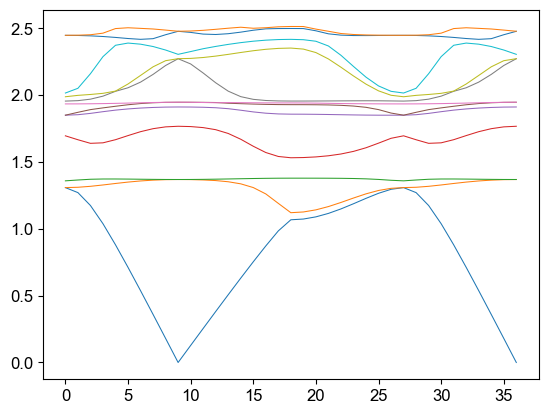

In [7]:
bands_sc = npzread("phc_an_files/phc3d_bands_sc_spheres_e_13.npz")["arr_0"]
plt.plot(bands_sc* 2π* c /0.5e-6 * ħeV);
# plt.xticks([0, 9, 18, 27], ["M", "Gamma", "X", "M"])

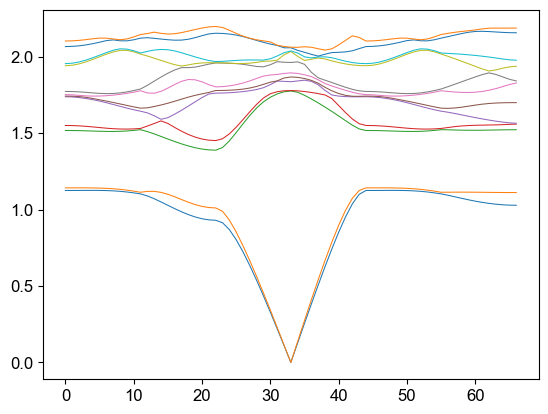

In [28]:
bands_sc = npzread("phc_an_files/phc3d_bands_wdpl_e_13.npz")["arr_0"]
plt.plot(bands_sc* 2π* c /0.5e-6 * ħeV);
# plt.xticks([0, 9, 18, 27], ["M", "Gamma", "X", "M"])